HardwareClassifier                            th1_per_trace_prediction              57942       0       0  188110 -> ACC =  23.55%
HardwareClassifier                            th2_per_trace_prediction              38474       0       0  207578 -> ACC =  15.64%
HardwareClassifier                            tot_per_trace_prediction              85902       0       0  160150 -> ACC =  34.91%
HardwareClassifier                            totd_per_trace_prediction             87989       0       0  158063 -> ACC =  35.76%
HardwareClassifier                            mops_per_trace_prediction             59557       0       0  186495 -> ACC =  24.21%


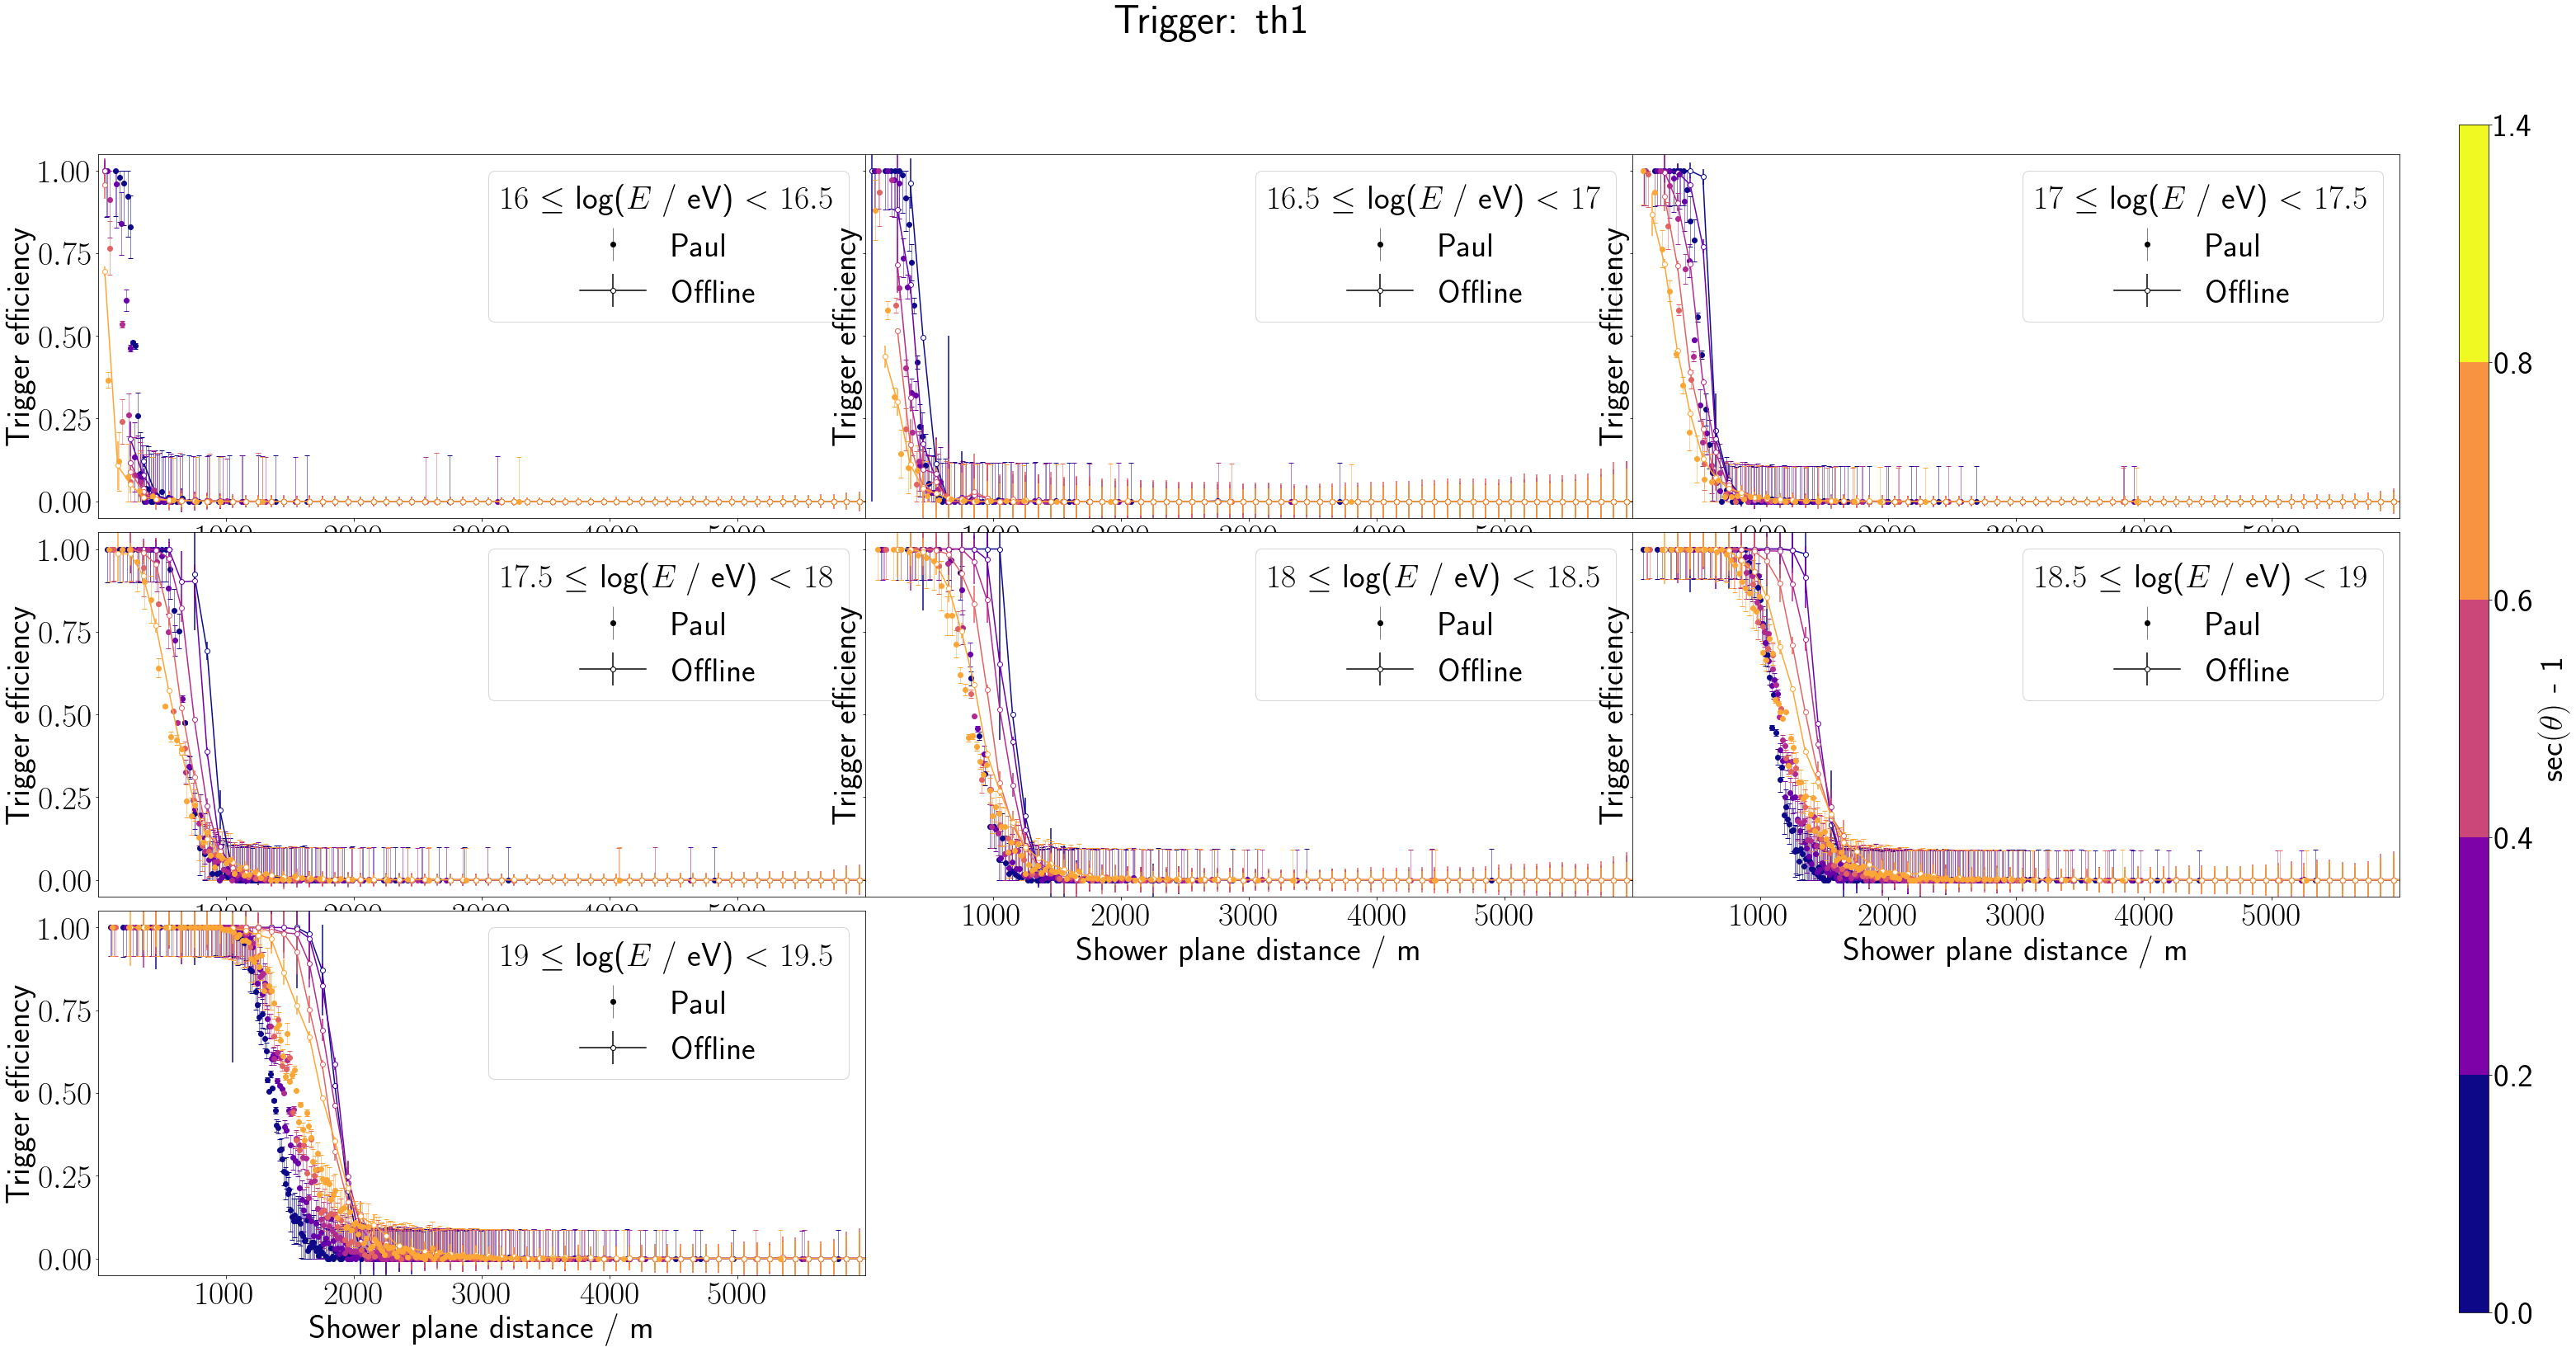

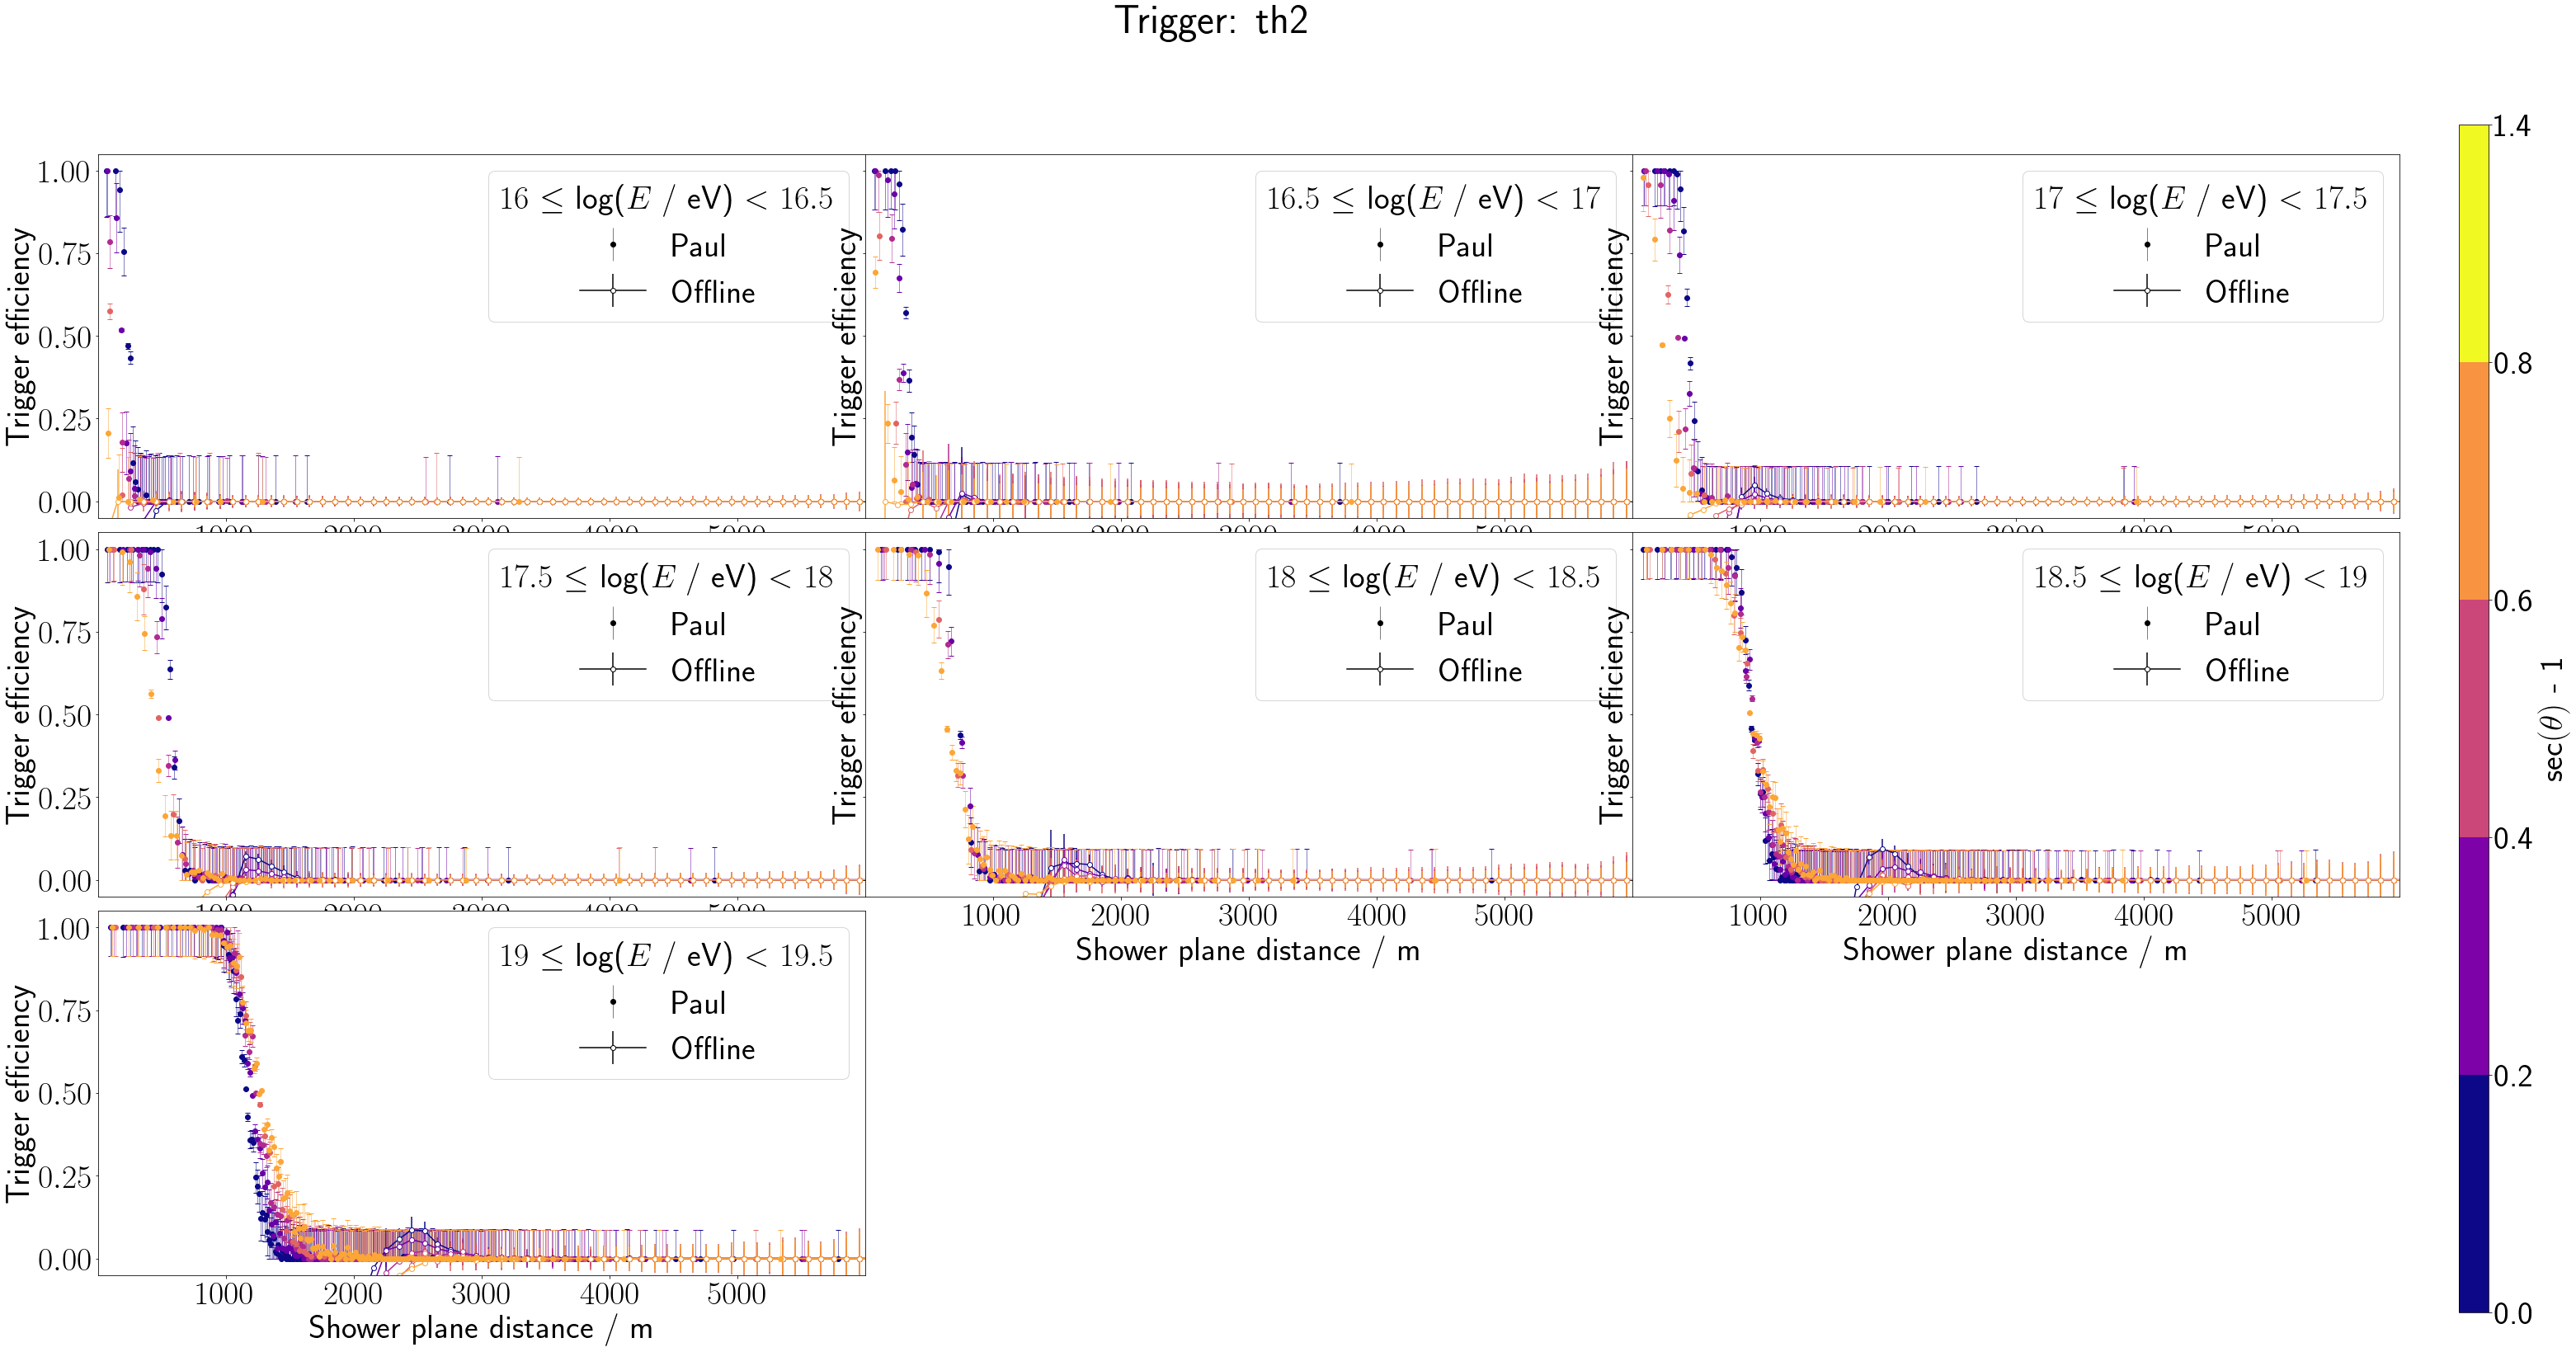

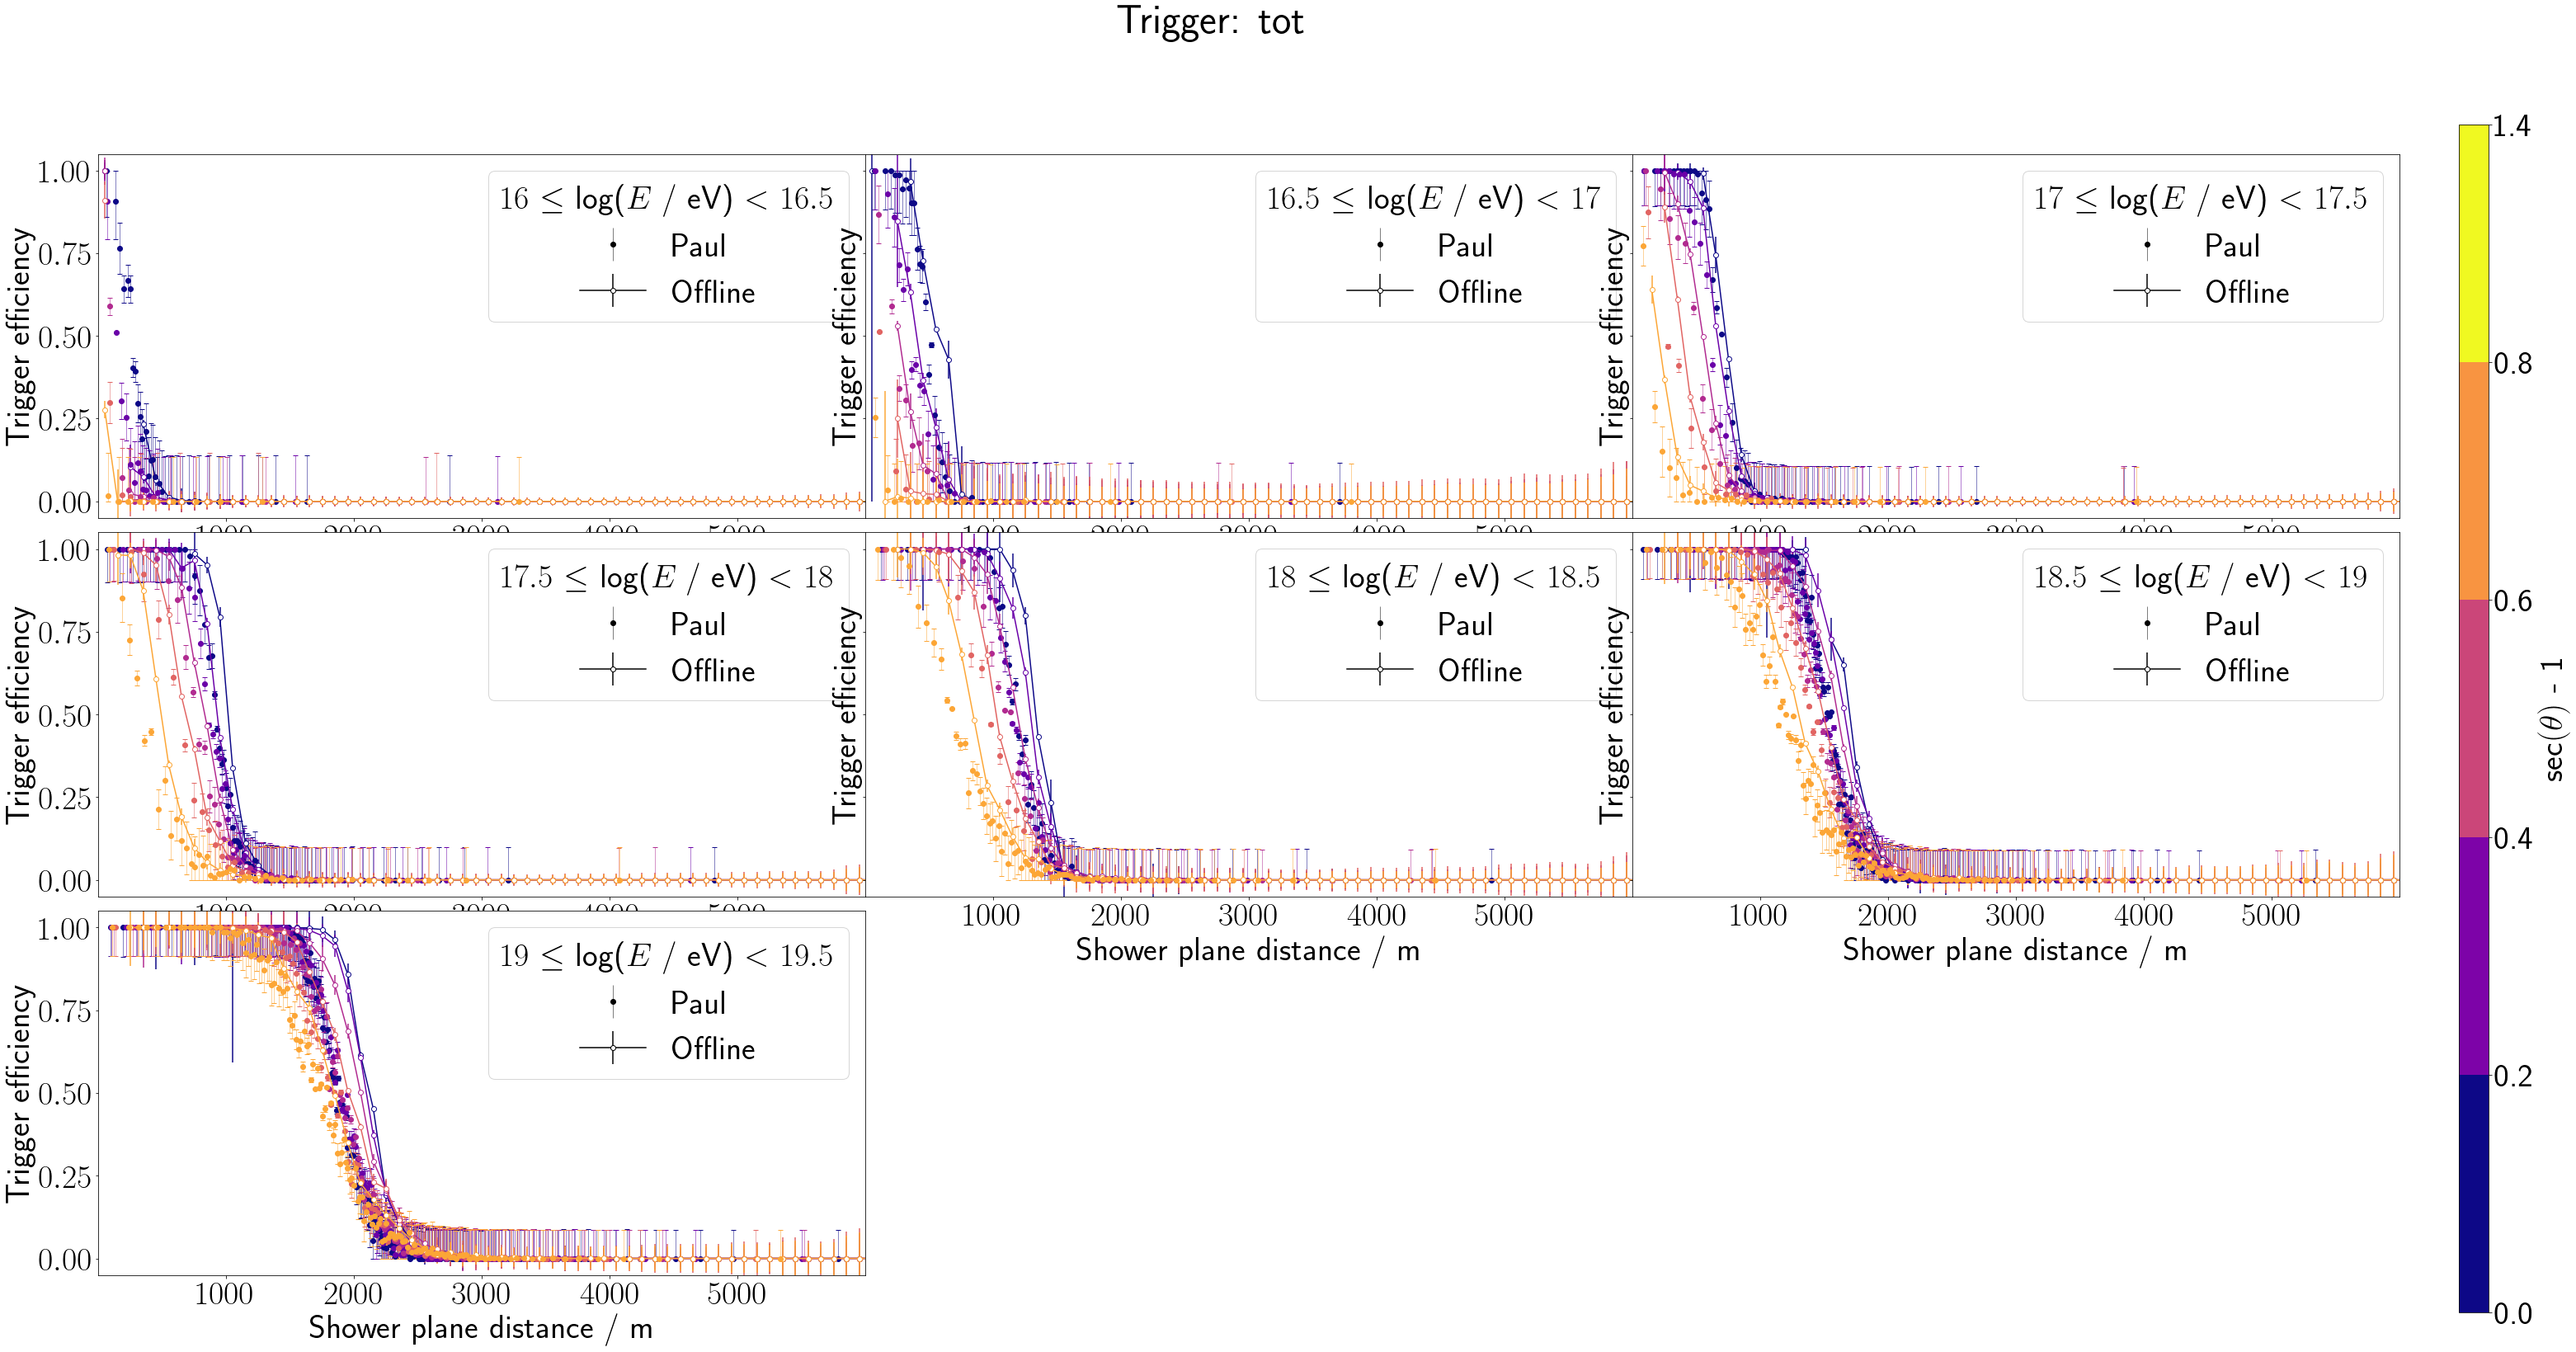

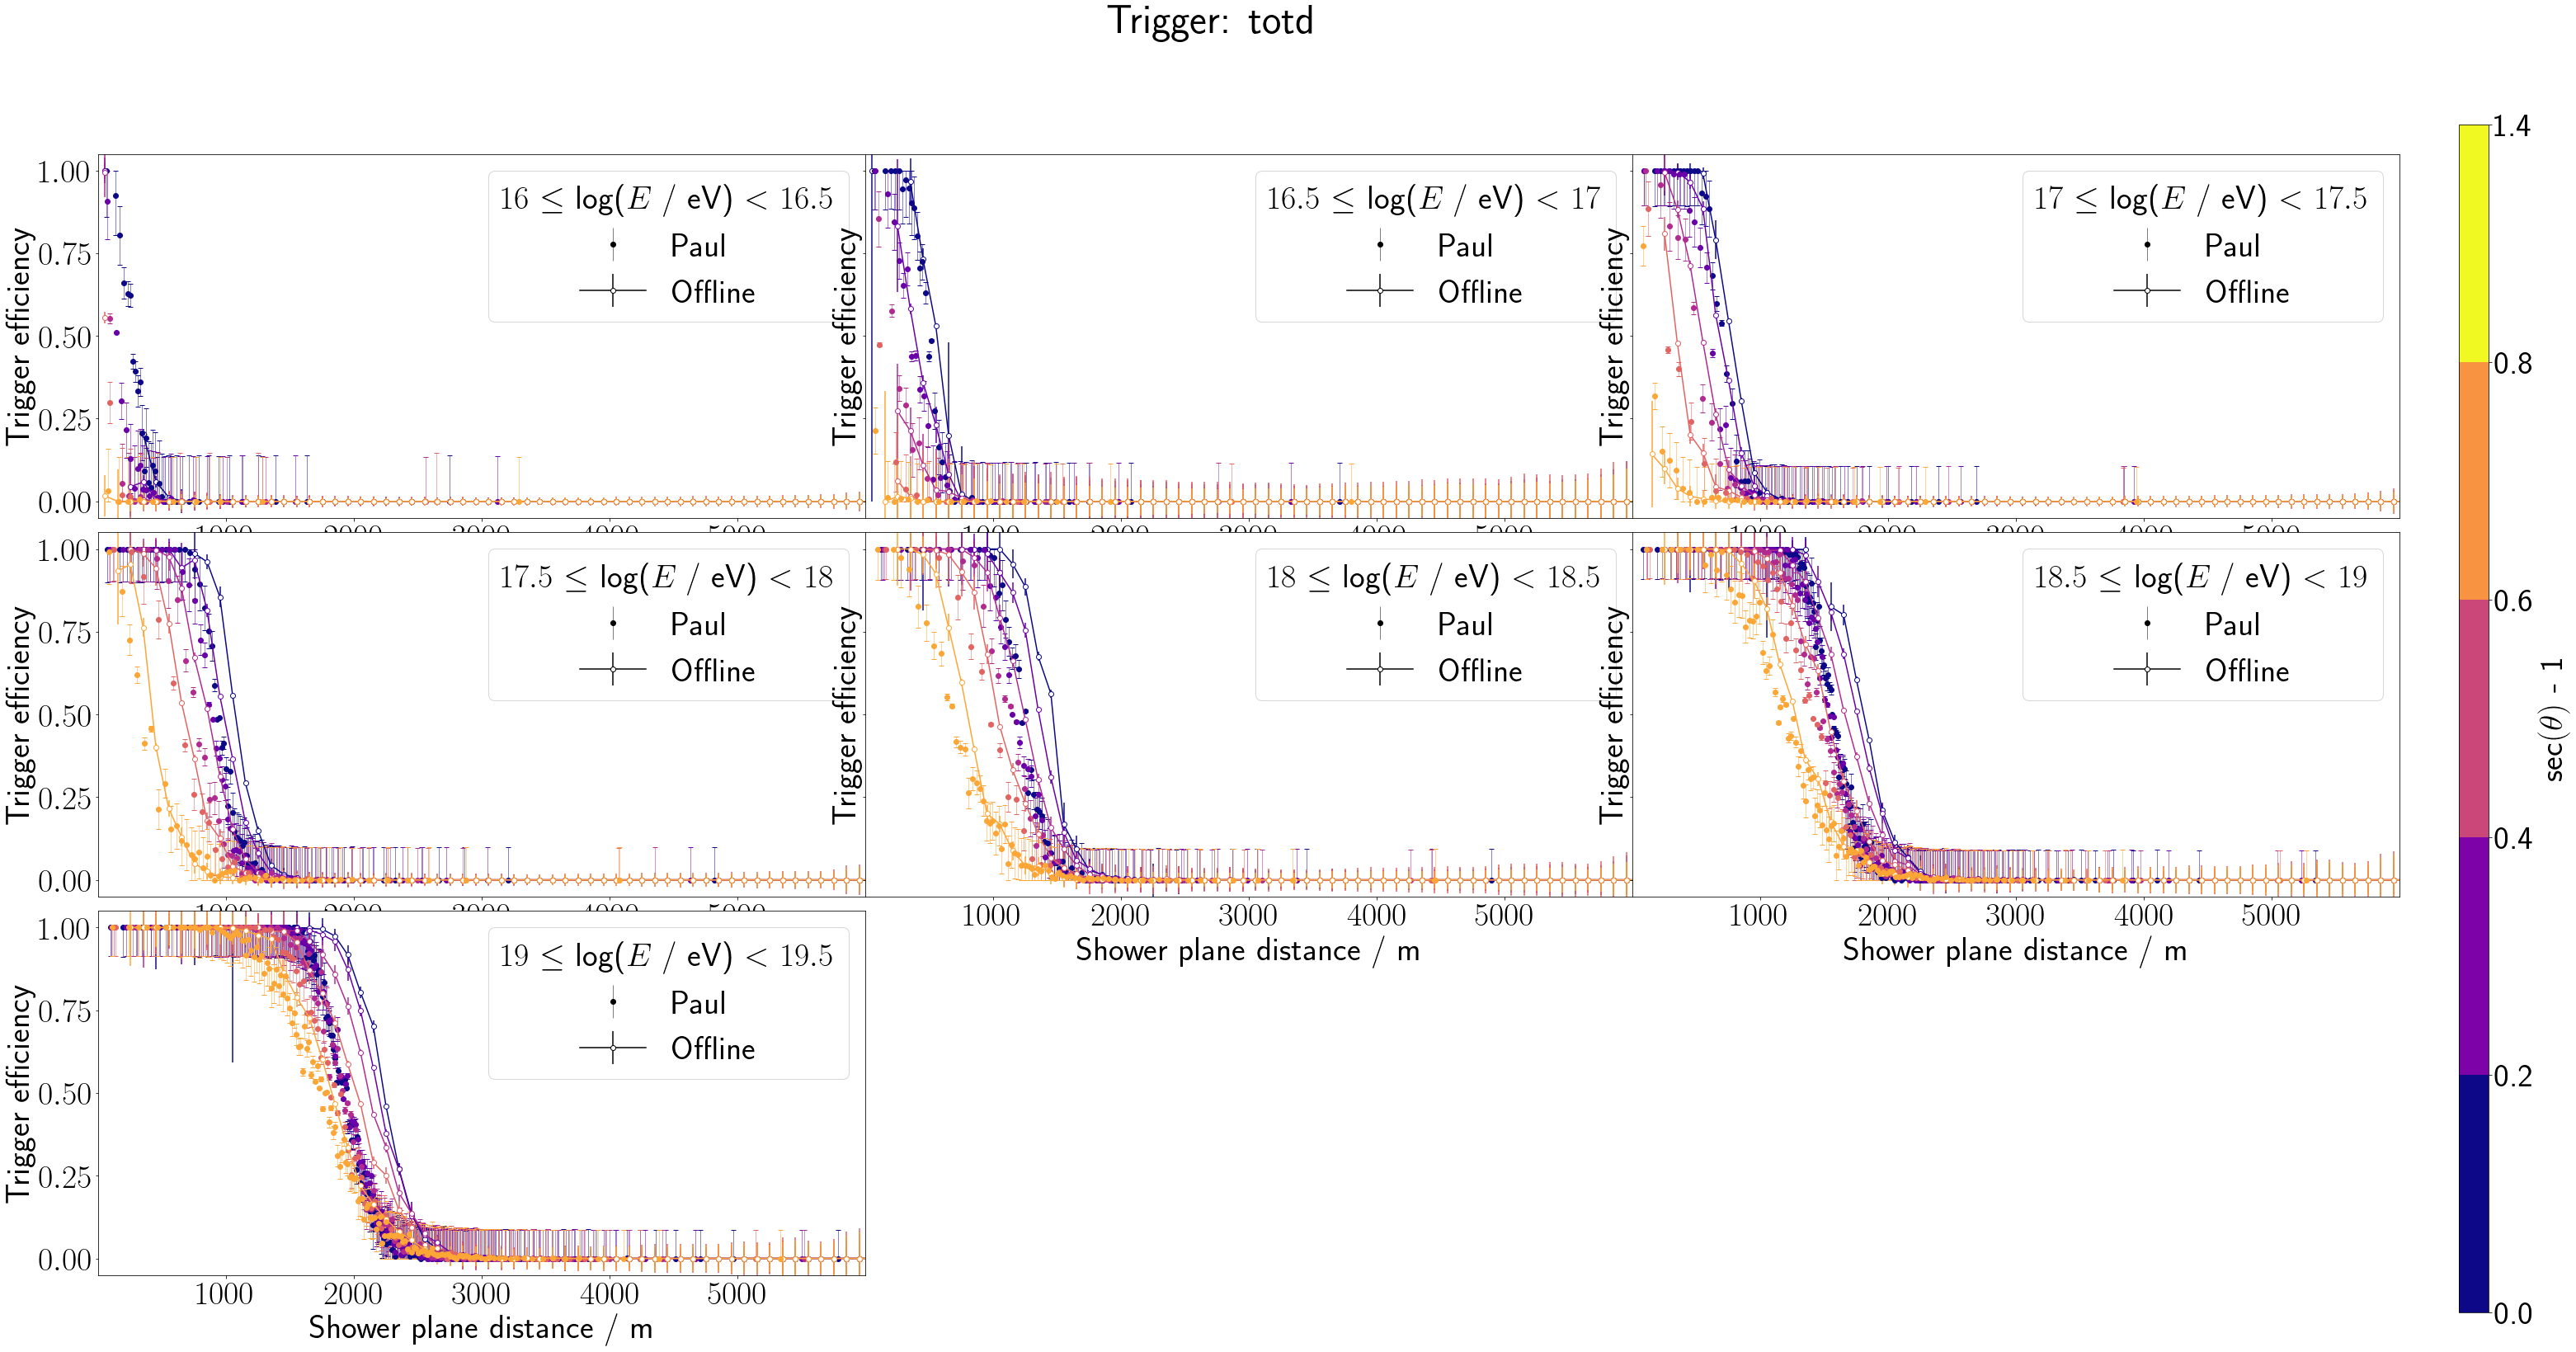

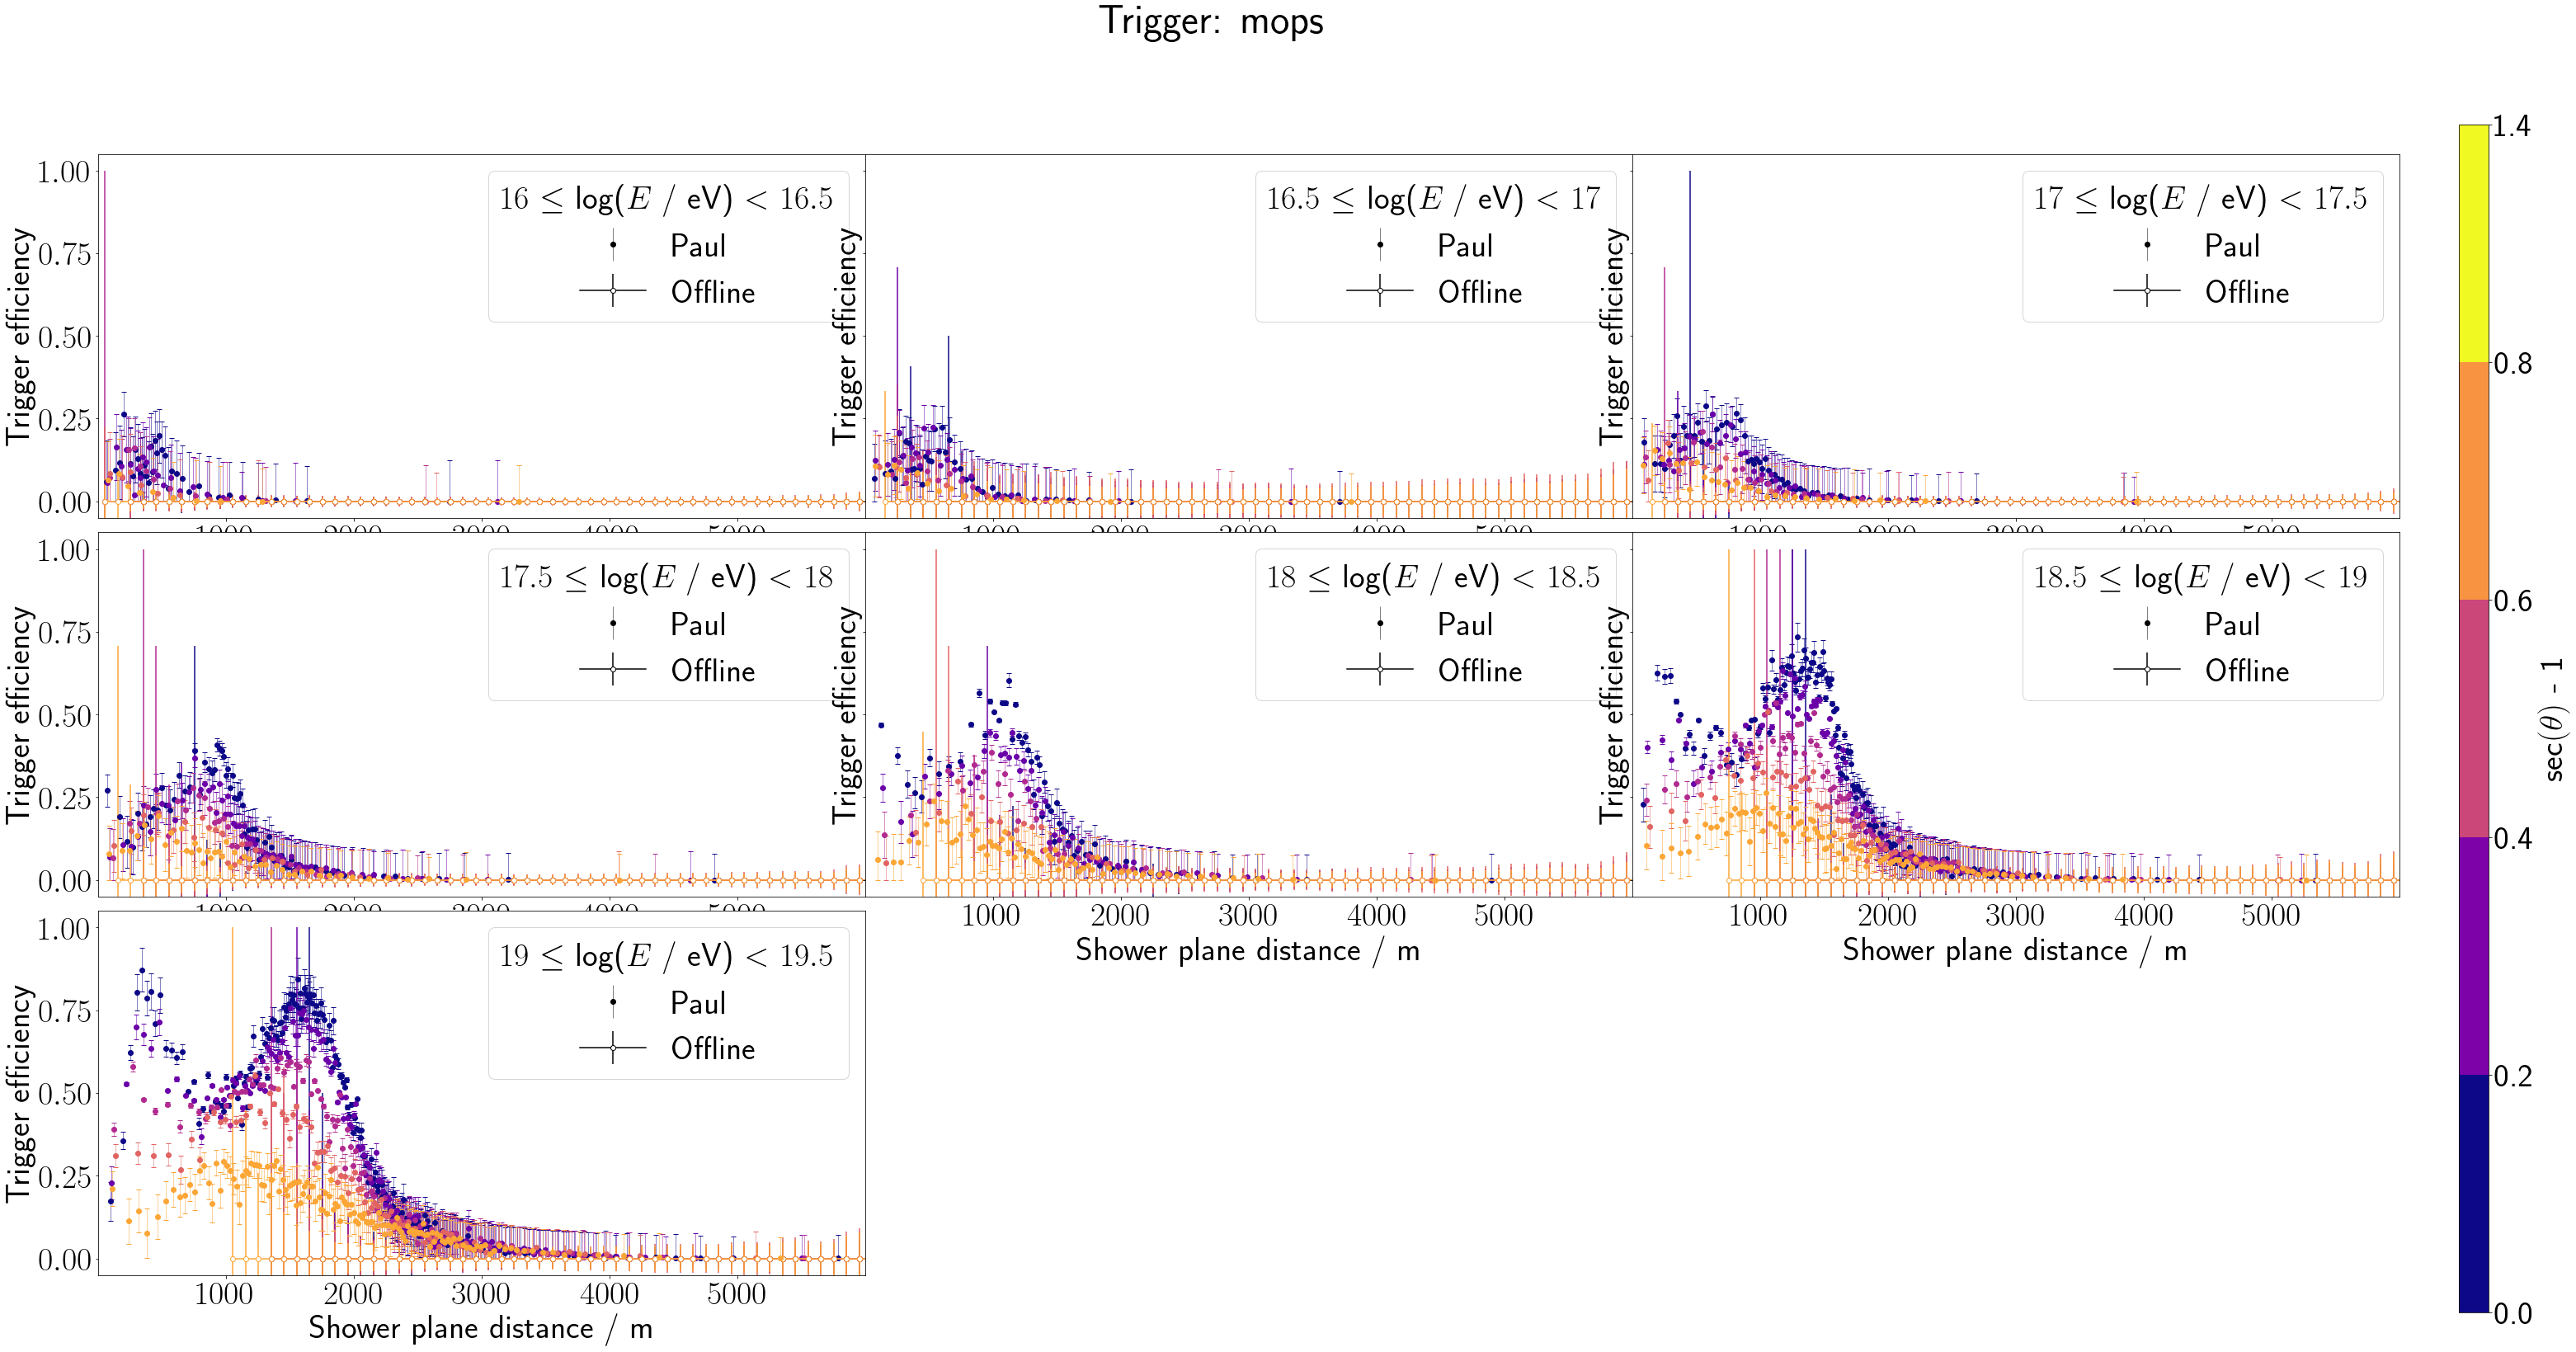

In [4]:
from Binaries import *
Trigger = HardwareClassifier()

c = lambda x, i : x.split("_")[i]
checksum = lambda x : sum([10*float(c(x,0)), 10*float(c(x,1)), float(c(x,3))/10, float(c(x,4)[:-4])/10])
root_path = "/cr/tempdata01/filip/QGSJET-II/LTP/BINNED/"
ldf_files = np.array(os.listdir(root_path))[np.argsort([checksum(file) for file in os.listdir(root_path )])]
ldf_files = [root_path + ldf_file for ldf_file in ldf_files]

for trigger in ["th1", "th2", "tot", "totd", "mops"]:
    fig, axes = plt.subplots(3,3, sharex = False, sharey = True, figsize = [50, 25])
    fig.suptitle(f"Trigger: {trigger}", fontsize = 50)
    axes[-1][-1].axis("off"), axes[-1][-2].axis("off")
    plt.ylim(-0.05, 1.05)

    TP, FP, TN, FN = Trigger.load_and_print_performance(trigger + "_per_trace_prediction")

    warnings.simplefilter("ignore", RuntimeWarning)
    colormap = cmap.get_cmap("plasma")
    bar_kwargs = \
    {
        "fmt" : "o",
        "elinewidth" : 0.5,
        "capsize" : 3
    }

    e_labels = [r"$16$", r"$16.5$", r"$17$", r"$17.5$", r"$18$", r"$18.5$", r"$19$", r"$19.5$"]            
    annotate = lambda e : e_labels[e] + r" $\leq$ log($E$ / eV) $<$ " + e_labels[e + 1]

    energy_bins = [10**16, 10**16.5, 10**17, 10**17.5, 10**18, 10**18.5, 10**19, 10**19.5]      # uniform in log(E)
    theta_bins =  [0.0000, 33.5600, 44.4200, 51.3200, 56.2500, 65.3700]                         # pseudo-uniform in sec(θ)

    miss_sorted = [[ [] for t in range(len(theta_bins) - 1) ] for e in range(len(energy_bins) - 1)]
    hits_sorted = [[ [] for t in range(len(theta_bins) - 1) ] for e in range(len(energy_bins) - 1)]

    # Sort predictions into bins of theta and energy
    for source, target in zip([TP, FN], [hits_sorted, miss_sorted]):

        spd, energy, theta = source[:, 0], source[:, 1], source[:, 2]
        energy_sorted = np.digitize(energy, energy_bins)
        theta_sorted = np.digitize(theta, theta_bins)

        for e, t, shower_plane_distance in zip(energy_sorted, theta_sorted, spd):
            target[e - 1][t - 1].append(shower_plane_distance)

    # Calculate efficiencies given sorted performances
    # axis 1 = sorted by primary particles' energy
    for e, (hits, misses) in enumerate(zip(hits_sorted, miss_sorted)):

        ax = axes[e // 3][e % 3]
        ax.set_xlim(0, 6000)
        ax.set_xlabel("Shower plane distance / m")
        ax.set_xticks([1e3, 2e3, 3e3, 4e3, 5e3])
        ax.set_ylabel("Trigger efficiency")
        ax.set_ylim(-0.05, 1.05)

        ax.errorbar([],[], yerr = [], c = "k", **bar_kwargs, label = "Paul")
        ax.errorbar([],[], yerr = [], c = "k", mfc = "w", fmt = "-o", label = "Offline")
        ax.legend(loc = "upper right", title = annotate(e))

        # axis 2 = sorted by zenith angle
        for t, (hits, misses) in enumerate(zip(hits, misses)):

            c = colormap(t / (len(theta_bins) - 1))

            spd, hit, miss, x_th1, x_th2, x_tot, x_totd, x_mops = np.loadtxt(ldf_files[e * 5 + t], unpack = True)
            err = lambda x, o : np.clip(1/(x + o)**2 * np.sqrt( x**3 + o**3 - 2 * np.sqrt((x * o)**3) ), 1e-5, 1)

            x = spd - 50

            if trigger == "th1": 
                y = x_th1 / (miss + x_th1)
                y_err = err(x_th1, miss)
            if trigger == "th2": 
                x_th2 = hit - x_th1 - x_tot - x_totd - x_mops
                y = x_th2 / (miss + hit)
                y_err = err(x_th2, miss)
            elif trigger == "tot": 
                y = x_tot / (miss + x_tot)
                y_err = err(x_tot, miss)
            elif trigger == "totd": 
                y = x_totd / (miss + x_totd)
                y_err = err(x_totd, miss)
            elif trigger == "mops":
                y = x_mops / (miss + x_mops)
                y_err = err(x_mops, miss)

            ax.errorbar(x, y, yerr = y_err, mfc = "w", color = c, fmt = "-o")

            LDF, (LDF_efficiency, LDF_prob_50, LDF_scale) = get_fit_function("/cr/tempdata01/filip/QGSJET-II/LDF/", e, t)

            all_data = hits + misses
            n_data_in_bins = int(50 * np.sqrt(e + 1))

            # have at least 7 bins or bins with >50 samples
            while True:
                n_bins = len(all_data) // n_data_in_bins
                probabilities = np.linspace(0, 1, n_bins)
                binning = mquantiles(all_data, prob = probabilities)
                bin_center = 0.5 * (binning[1:] + binning[:-1])
                n_all, _ = np.histogram(all_data, bins = binning)

                if len(n_all) <= 7: 
                    n_data_in_bins -= 10
                    if n_data_in_bins == 50: break
                else: break

            x, _ = np.histogram(hits, bins = binning)
            o, _ = np.histogram(misses, bins = binning)
            efficiency = x / (x + o) * LDF(bin_center)
            efficiency_err = 1/n_all**2 * np.sqrt( x**3 + o**3 - 2 * np.sqrt((x * o)**3) )          # lack LDF error part here !!
            efficiency_err[efficiency_err == 0] = 1e-3                                              # such that residuals are finite

            # if trigger == "tot": efficiency_cache = efficiency
            # if trigger == "totd": efficiency = efficiency - efficiency_cache

            upper = np.clip(efficiency + efficiency_err, 0, 1)
            lower = np.clip(efficiency - efficiency_err, 0, 1)

            ax.errorbar(bin_center, efficiency, yerr = [efficiency - lower, upper - efficiency], color = c, **bar_kwargs)

    norm = BoundaryNorm(theta_bins, colormap.N)
    ax2 = fig.add_axes([0.92, 0.1, 0.01, 0.8])
    cbar = ColorbarBase(ax2, cmap=colormap, norm=norm, label = r"sec$(\theta)$ - 1")
    cbar.set_ticks(theta_bins)
    cbar.set_ticklabels(["0.0", "0.2", "0.4", "0.6", "0.8", "1.4"])

    plt.subplots_adjust(hspace = 0.04, wspace = 0)

    warnings.simplefilter("default", RuntimeWarning)

HardwareClassifier                            th2_q_peak_compatibility              71840       0       0  174212 -> ACC =  29.20%
HardwareClassifier                            tot_q_peak_compatibility              95103       0       0  150949 -> ACC =  38.65%
HardwareClassifier                            totd_q_peak_compatibility             96401       0       0  149651 -> ACC =  39.18%


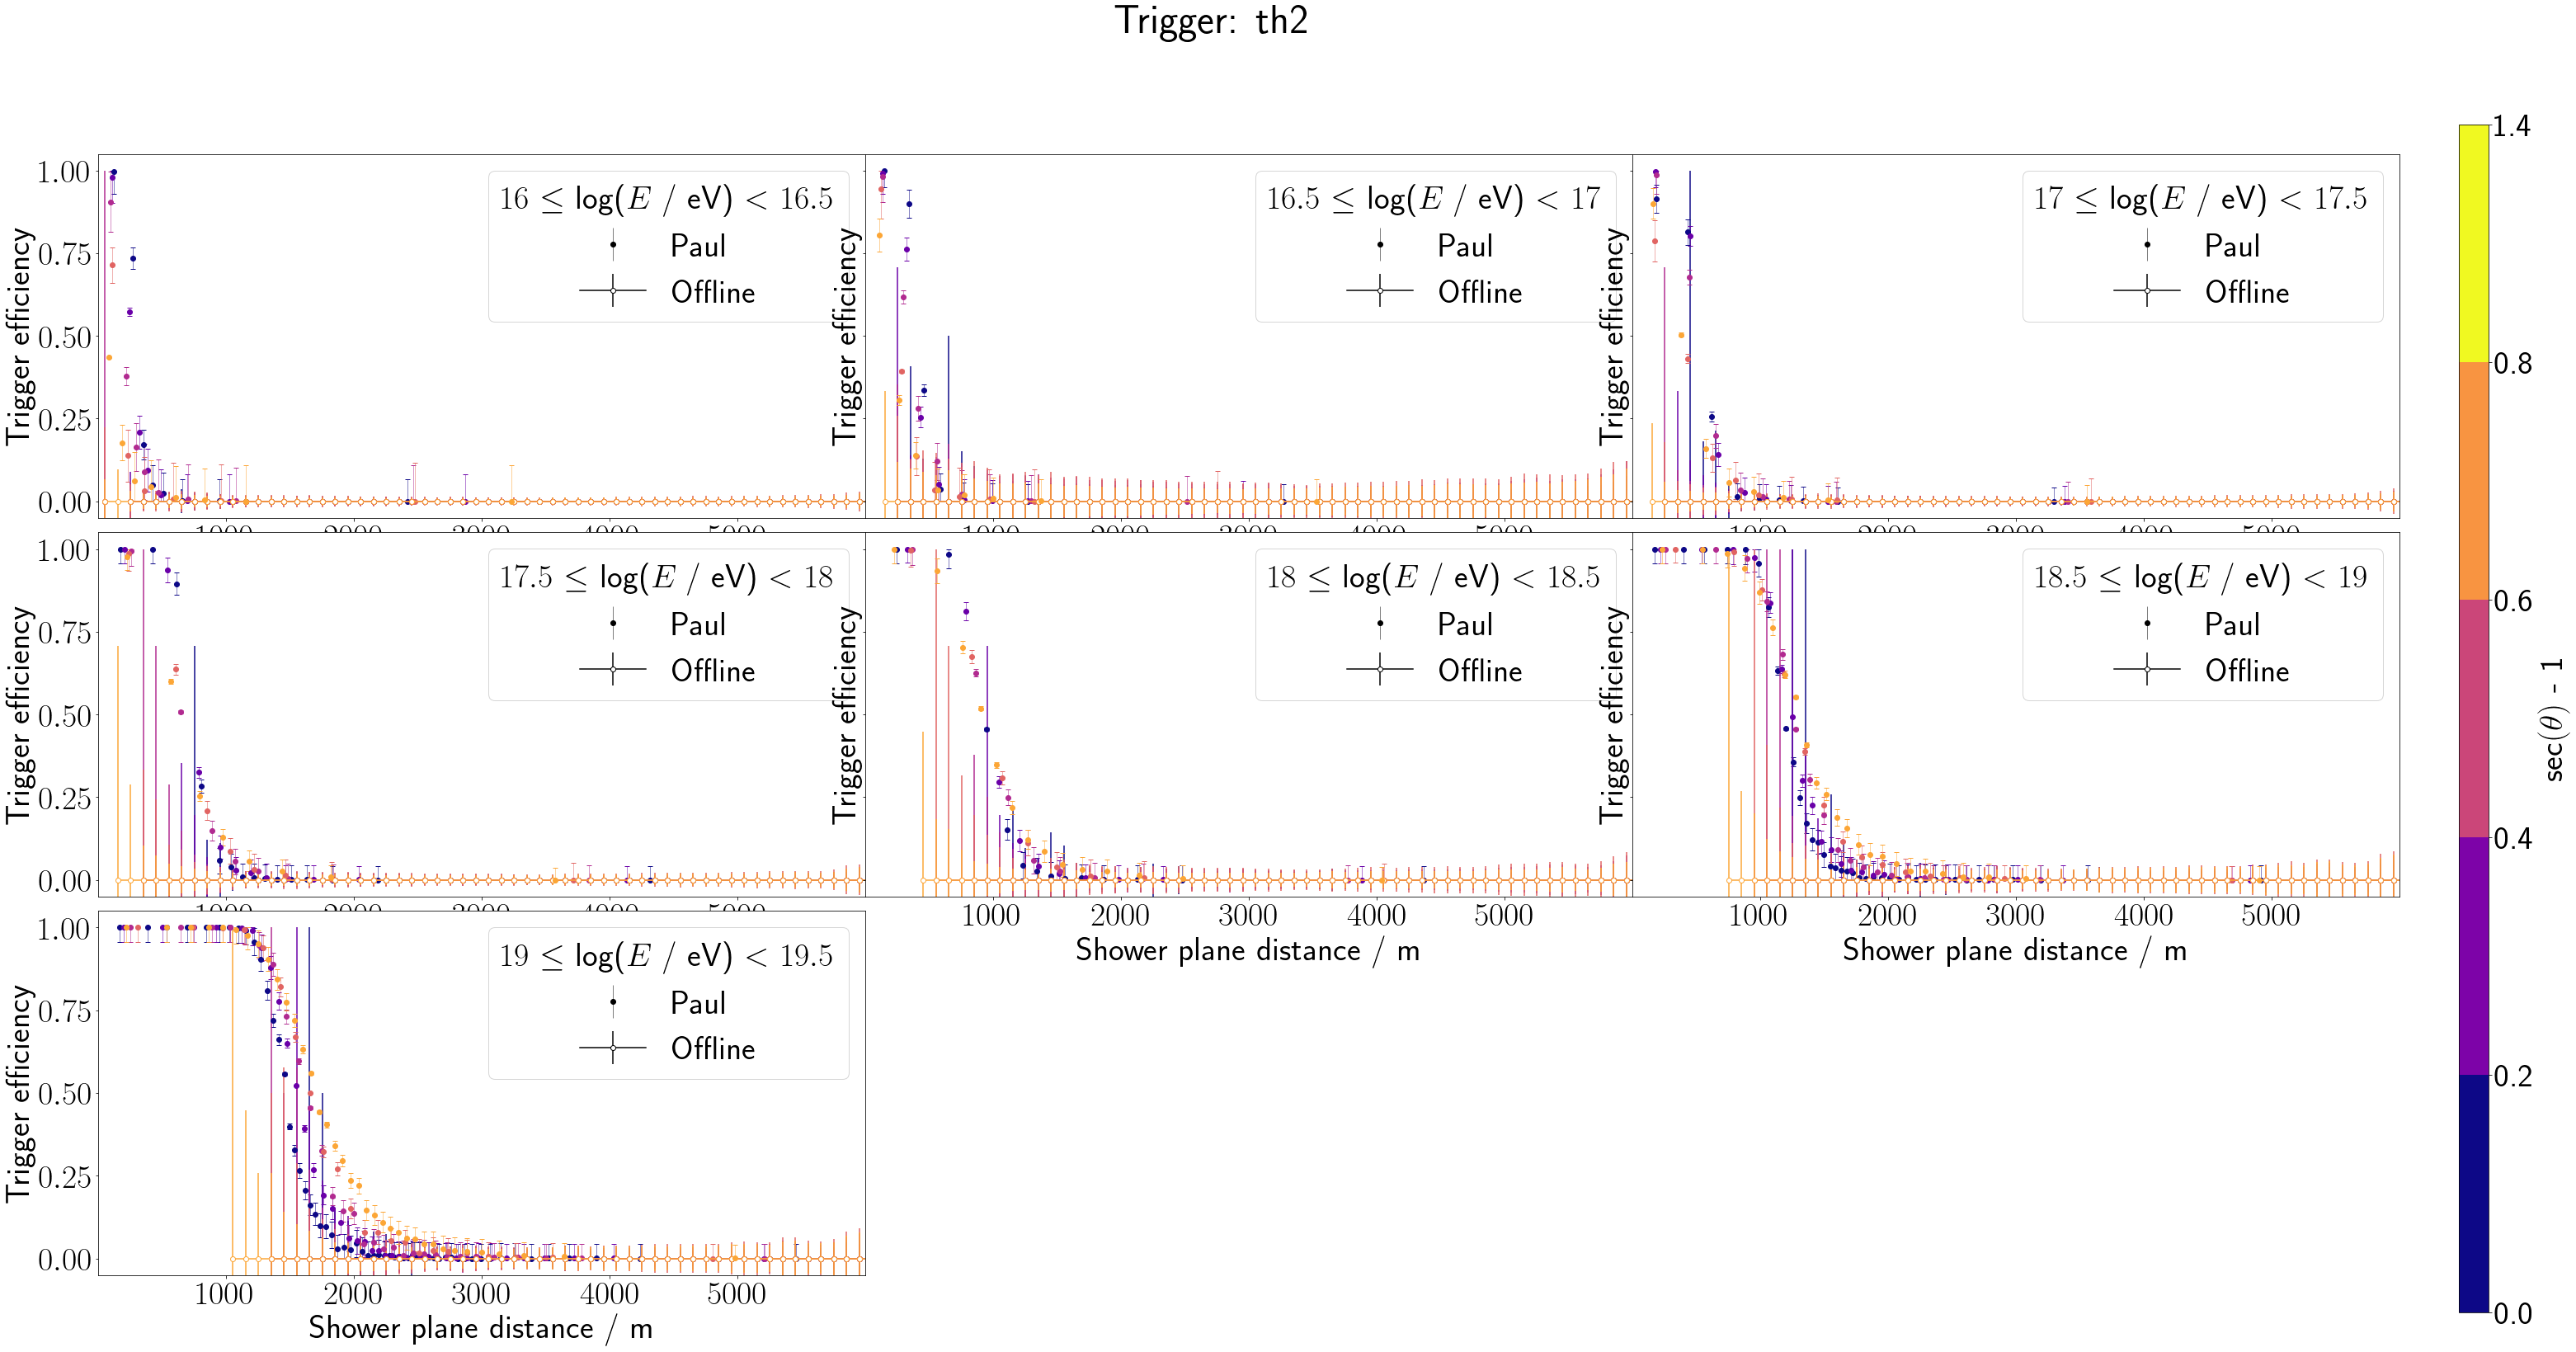

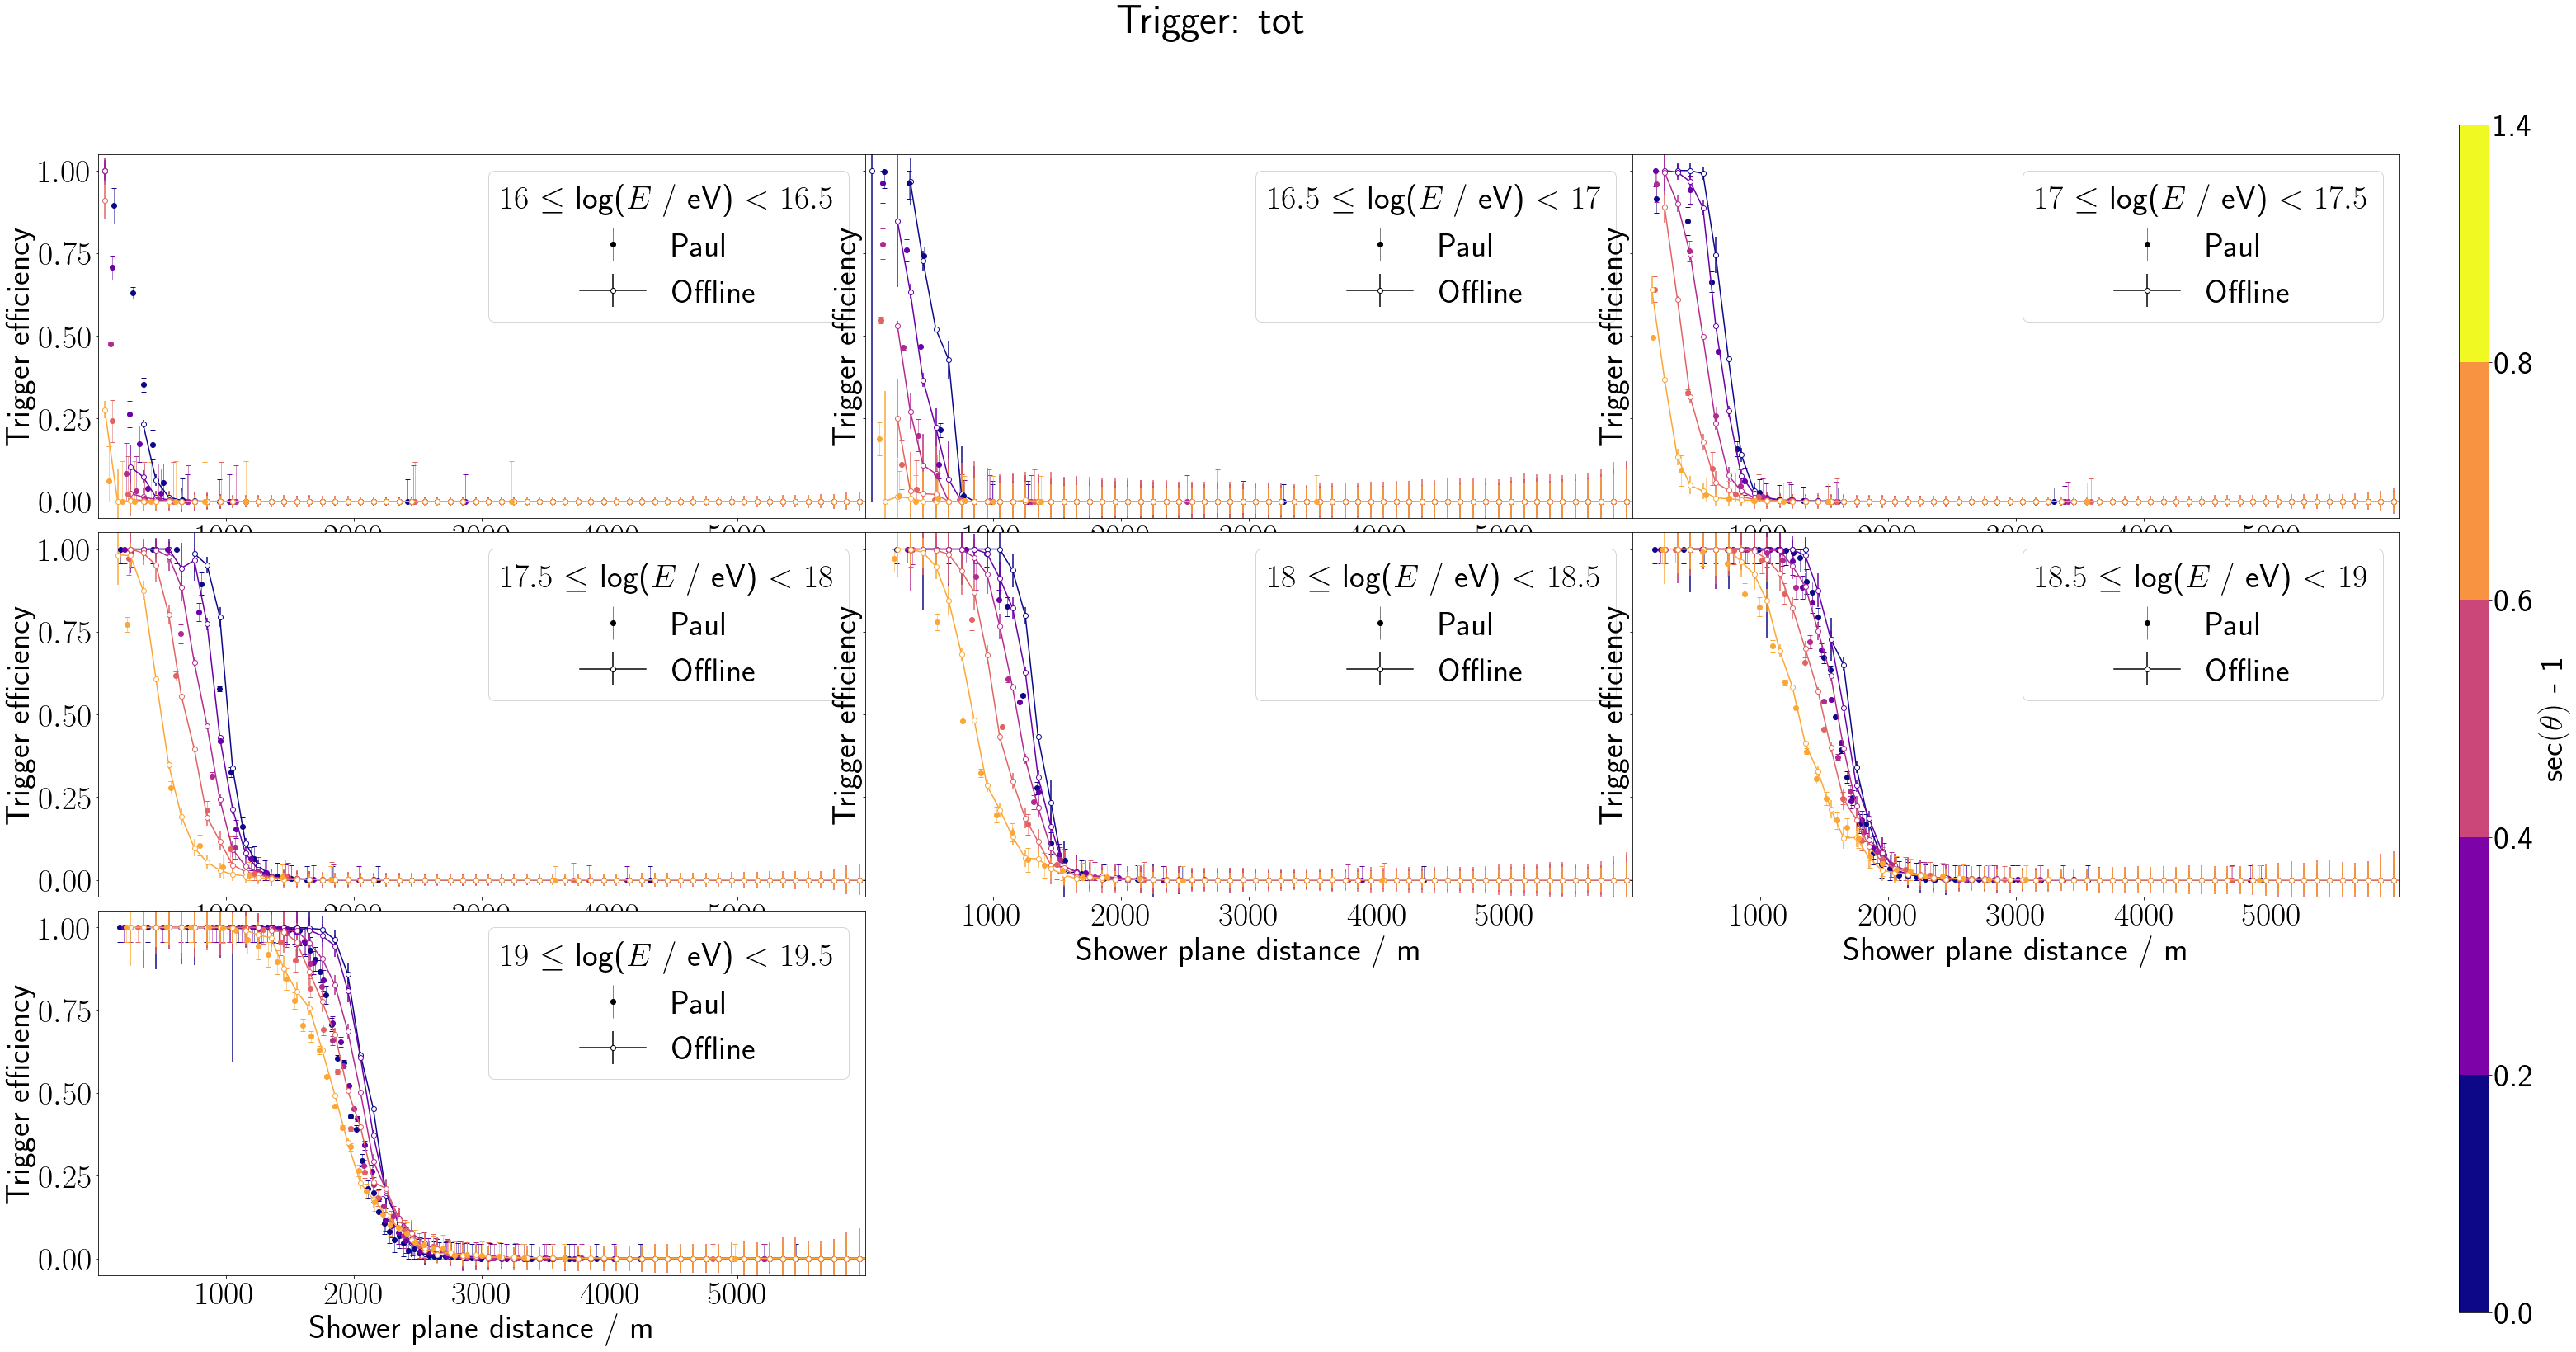

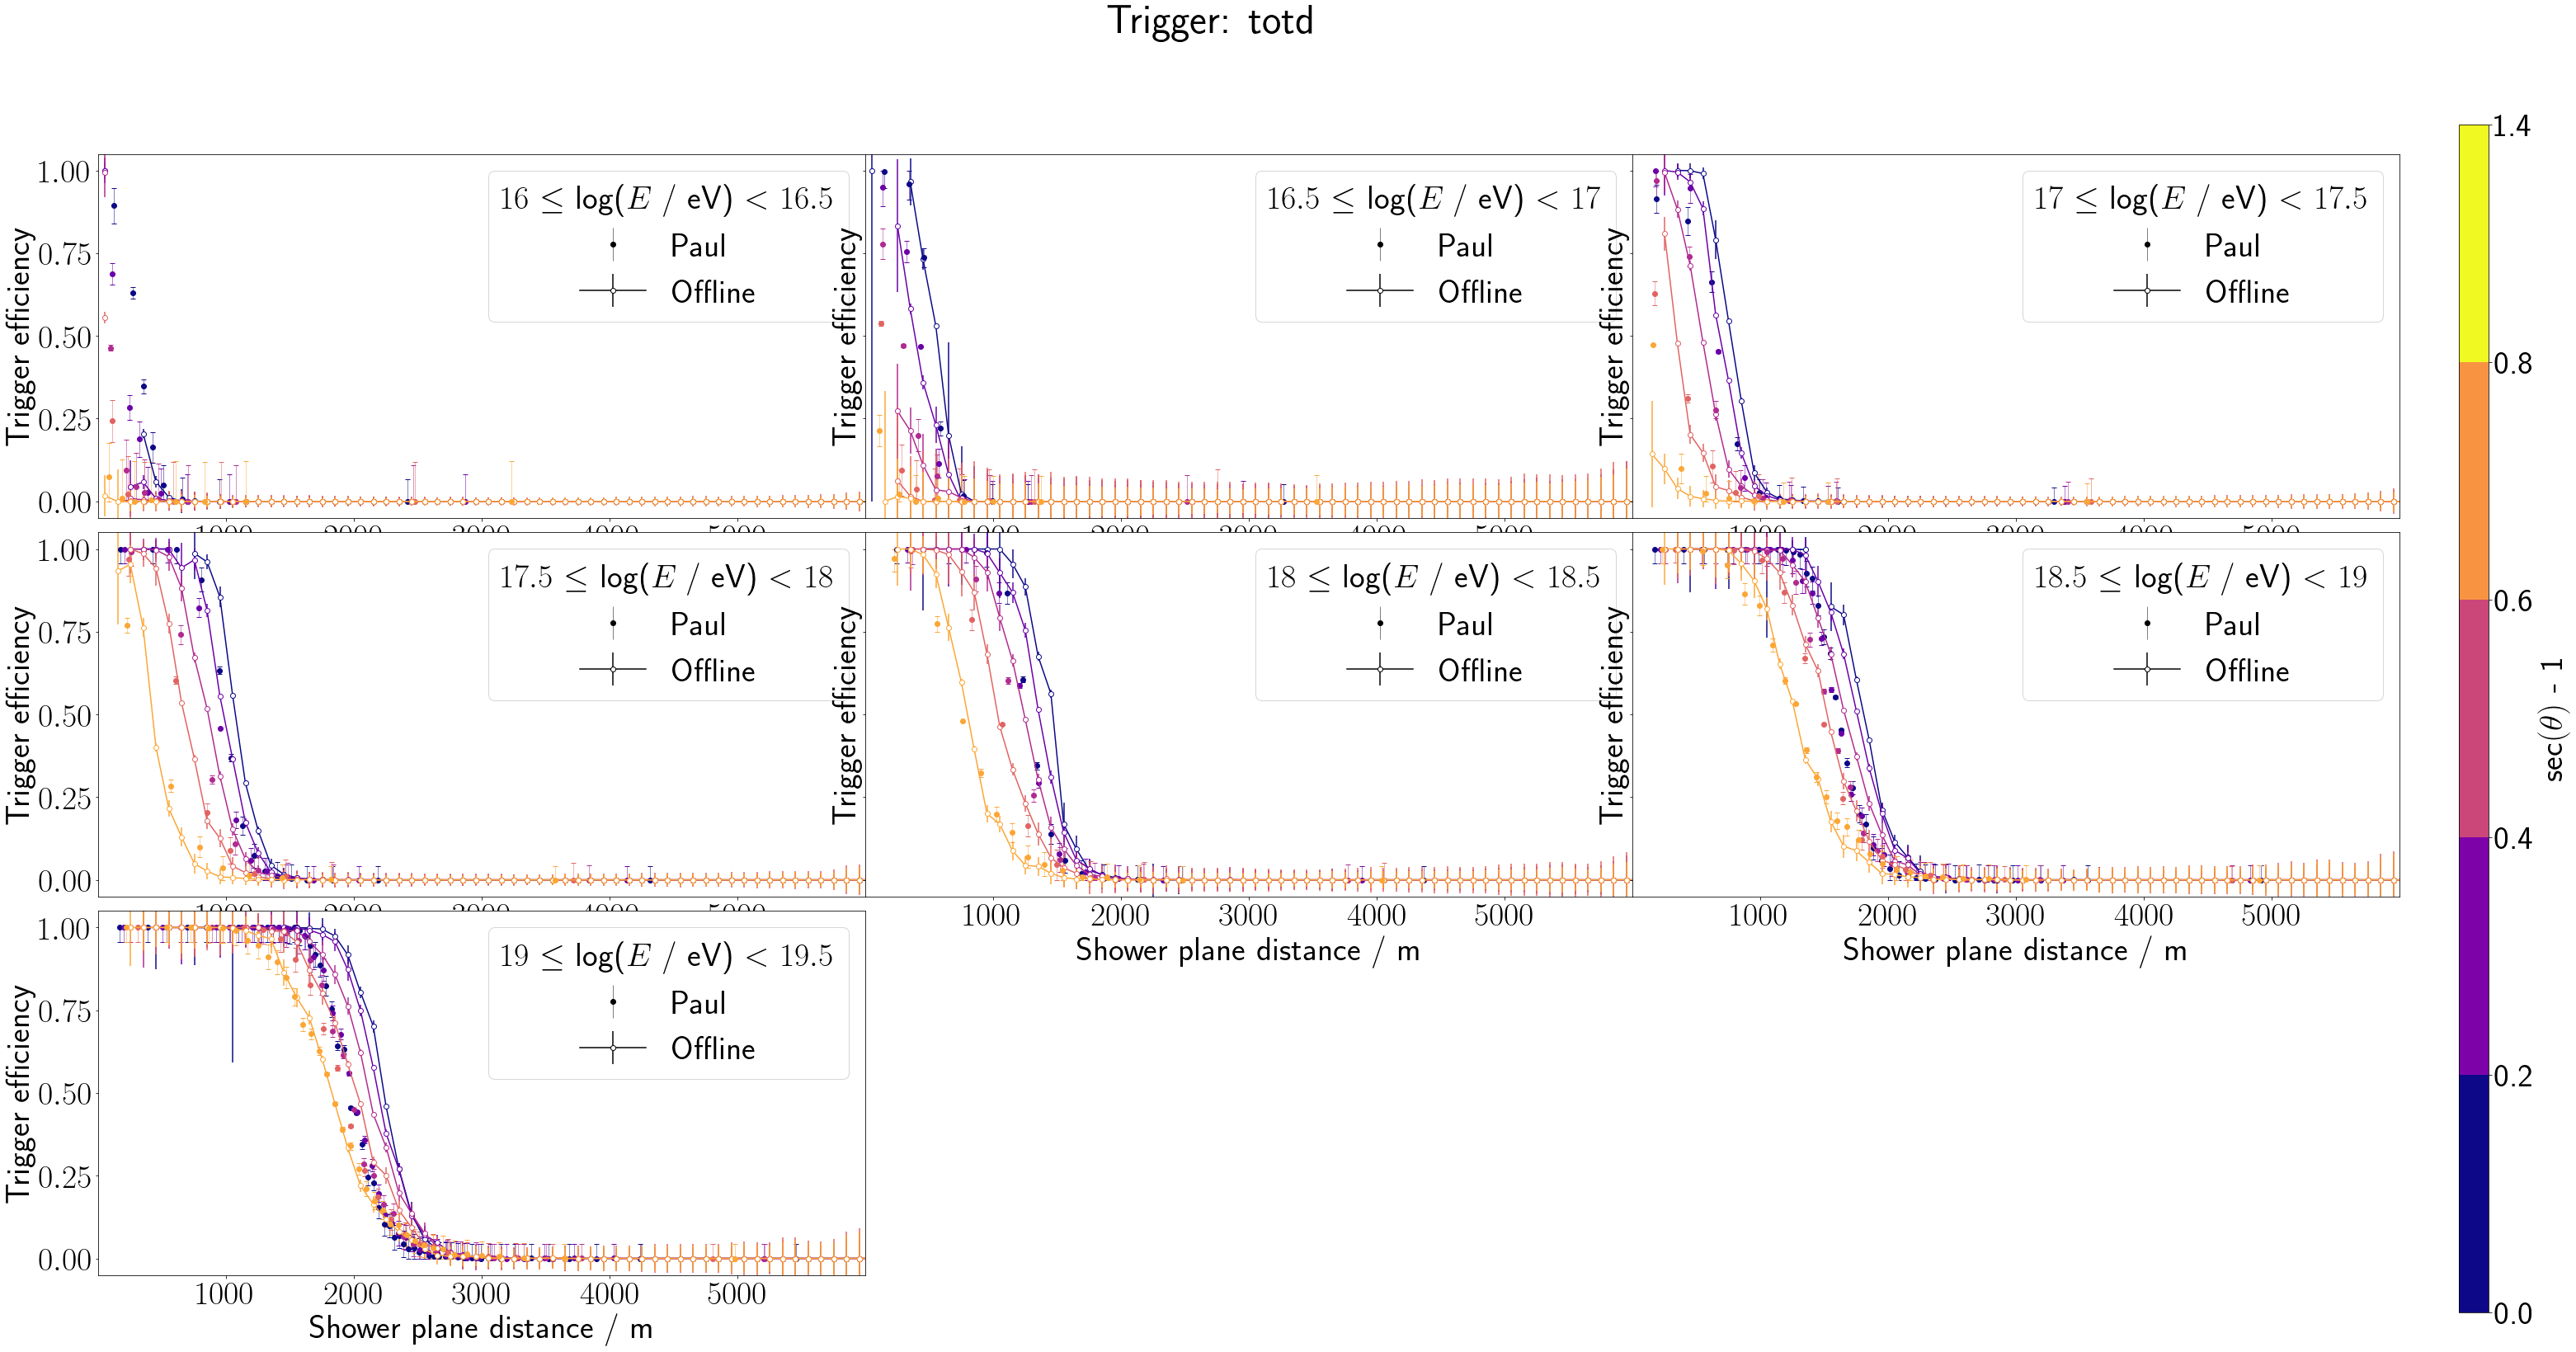

In [3]:
from Binaries import *
Trigger = HardwareClassifier()

c = lambda x, i : x.split("_")[i]
checksum = lambda x : sum([10*float(c(x,0)), 10*float(c(x,1)), float(c(x,3))/10, float(c(x,4)[:-4])/10])
root_path = "/cr/tempdata01/filip/QGSJET-II/LTP/BINNED/"
ldf_files = np.array(os.listdir(root_path))[np.argsort([checksum(file) for file in os.listdir(root_path )])]
ldf_files = [root_path + ldf_file for ldf_file in ldf_files]

for trigger in ["th2", "tot", "totd"]:
    fig, axes = plt.subplots(3,3, sharex = False, sharey = True, figsize = [50, 25])
    fig.suptitle(f"Trigger: {trigger}", fontsize = 50)
    axes[-1][-1].axis("off"), axes[-1][-2].axis("off")
    plt.ylim(-0.05, 1.05)

    TP, FP, TN, FN = Trigger.load_and_print_performance(trigger + "_q_peak_compatibility")

    warnings.simplefilter("ignore", RuntimeWarning)
    colormap = cmap.get_cmap("plasma")
    bar_kwargs = \
    {
        "fmt" : "o",
        "elinewidth" : 0.5,
        "capsize" : 3
    }

    e_labels = [r"$16$", r"$16.5$", r"$17$", r"$17.5$", r"$18$", r"$18.5$", r"$19$", r"$19.5$"]            
    annotate = lambda e : e_labels[e] + r" $\leq$ log($E$ / eV) $<$ " + e_labels[e + 1]

    energy_bins = [10**16, 10**16.5, 10**17, 10**17.5, 10**18, 10**18.5, 10**19, 10**19.5]      # uniform in log(E)
    theta_bins =  [0.0000, 33.5600, 44.4200, 51.3200, 56.2500, 65.3700]                         # pseudo-uniform in sec(θ)

    miss_sorted = [[ [] for t in range(len(theta_bins) - 1) ] for e in range(len(energy_bins) - 1)]
    hits_sorted = [[ [] for t in range(len(theta_bins) - 1) ] for e in range(len(energy_bins) - 1)]

    # Sort predictions into bins of theta and energy
    for source, target in zip([TP, FN], [hits_sorted, miss_sorted]):

        spd, energy, theta = source[:, 0], source[:, 1], source[:, 2]
        energy_sorted = np.digitize(energy, energy_bins)
        theta_sorted = np.digitize(theta, theta_bins)

        for e, t, shower_plane_distance in zip(energy_sorted, theta_sorted, spd):
            target[e - 1][t - 1].append(shower_plane_distance)

    # Calculate efficiencies given sorted performances
    # axis 1 = sorted by primary particles' energy
    for e, (hits, misses) in enumerate(zip(hits_sorted, miss_sorted)):

        ax = axes[e // 3][e % 3]
        ax.set_xlim(0, 6000)
        ax.set_xlabel("Shower plane distance / m")
        ax.set_xticks([1e3, 2e3, 3e3, 4e3, 5e3])
        ax.set_ylabel("Trigger efficiency")
        ax.set_ylim(-0.05, 1.05)

        ax.errorbar([],[], yerr = [], c = "k", **bar_kwargs, label = "Paul")
        ax.errorbar([],[], yerr = [], c = "k", mfc = "w", fmt = "-o", label = "Offline")
        ax.legend(loc = "upper right", title = annotate(e))

        # axis 2 = sorted by zenith angle
        for t, (hits, misses) in enumerate(zip(hits, misses)):

            c = colormap(t / (len(theta_bins) - 1))

            spd, hit, miss, x_th1, x_th2, x_tot, x_totd, x_mops = np.loadtxt(ldf_files[e * 5 + t], unpack = True)
            err = lambda x, o : np.clip(1/(x + o)**2 * np.sqrt( x**3 + o**3 - 2 * np.sqrt((x * o)**3) ), 1e-5, 1)

            x = spd - 50

            if trigger == "th1": 
                y = x_th1 / (miss + x_th1)
                y_err = err(x_th1, miss)
            if trigger == "th2": 
                y = x_th2 / (miss + x_th2)
                y_err = err(x_th2, miss)
            elif trigger == "tot": 
                y = x_tot / (miss + x_tot)
                y_err = err(x_tot, miss)
            elif trigger == "totd": 
                y = x_totd / (miss + x_totd)
                y_err = err(x_totd, miss)
            elif trigger == "mops":
                y = x_mops / (miss + x_mops)
                y_err = err(x_mops, miss)

            ax.errorbar(x, y, yerr = y_err, mfc = "w", color = c, fmt = "-o")

            LDF, (LDF_efficiency, LDF_prob_50, LDF_scale) = get_fit_function("/cr/tempdata01/filip/QGSJET-II/LDF/", e, t)

            all_data = hits + misses
            n_data_in_bins = 500

            # have at least 7 bins or bins with >50 samples
            while True:
                n_bins = len(all_data) // n_data_in_bins
                probabilities = np.linspace(0, 1, n_bins)
                binning = mquantiles(all_data, prob = probabilities)
                bin_center = 0.5 * (binning[1:] + binning[:-1])
                n_all, _ = np.histogram(all_data, bins = binning)

                if len(n_all) <= 7: 
                    n_data_in_bins -= 10
                    if n_data_in_bins == 50: break
                else: break

            x, _ = np.histogram(hits, bins = binning)
            o, _ = np.histogram(misses, bins = binning)
            efficiency = x / (x + o) * LDF(bin_center)
            efficiency_err = 1/n_all**2 * np.sqrt( x**3 + o**3 - 2 * np.sqrt((x * o)**3) )          # lack LDF error part here !!
            efficiency_err[efficiency_err == 0] = 1e-3                                              # such that residuals are finite

            # if trigger == "tot": efficiency_cache = efficiency
            # if trigger == "totd": efficiency = efficiency - efficiency_cache

            upper = np.clip(efficiency + efficiency_err, 0, 1)
            lower = np.clip(efficiency - efficiency_err, 0, 1)

            ax.errorbar(bin_center, efficiency, yerr = [efficiency - lower, upper - efficiency], color = c, **bar_kwargs)

    norm = BoundaryNorm(theta_bins, colormap.N)
    ax2 = fig.add_axes([0.92, 0.1, 0.01, 0.8])
    cbar = ColorbarBase(ax2, cmap=colormap, norm=norm, label = r"sec$(\theta)$ - 1")
    cbar.set_ticks(theta_bins)
    cbar.set_ticklabels(["0.0", "0.2", "0.4", "0.6", "0.8", "1.4"])

    plt.subplots_adjust(hspace = 0.04, wspace = 0)

    warnings.simplefilter("default", RuntimeWarning)

In [1]:
from Binaries import *

Trigger = HardwareClassifier()

Trigger.load_and_print_performance("asdasd_lol")


Classifier                                    Dataset                                  TP      FP      TN      FN


FileNotFoundError: [Errno 2] No such file or directory: '/cr/data01/filip/models/HardwareClassifier/ROC_curve/asdasd_lol/true_negatives.csv'